In [2]:
!pip install catboost
!pip install causalgraphicalmodels

     |████████████████████████████████| 76.3 MB 22 kB/s 


In [70]:
def generate(size, env=1):
    data = pd.DataFrame()
    x1 = np.random.normal(loc=0.0, scale=1.0, size=size) * env
    data['x1'] = x1
    data['y'] = 2 * data['x1'] + np.random.normal(0, 0.5, size=size)
    data['x2'] = 1.5 * data['y'] * env * env + np.random.normal(0, 0.5, size=size)

    return data[['x1', 'x2', 'y']]

In [71]:
def generate_do(size, x1=None, x2=None, x3=None):
    data = pd.DataFrame()

    data['x2'] = np.random.normal(0, 0.4, size=size)
    if x2 is not None:
        data['x2'] = x2

    data['x1'] = 1.5 * data['x2'] + np.random.normal(0, 0.5, size=size)
    if x1 is not None:
        data['x1'] = x1

    data['x3'] = -2 * data['x2'] + + np.random.normal(0, 0.5, size=size)
    if x3 is not None:
        data['3'] = x3

    return data[['x1', 'x2', 'x3']]

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

import warnings

warnings.filterwarnings('ignore')

Пусть имеется структурная каузальная модель из двух переменных $X \rightarrow Y$:

$$
X = U_0
$$
$$
Y = f(X) + U_1
$$

Знаем, что $U_0$ и $U_1$ независимы, что аналогично независимости $X$ и $Y - f(X)$. 

Также в таком случае верно, что $Y - \mathbb{E}[Y|X]$ и $X$ независимы, но обратное неверно: $X - \mathbb{E}[X|Y]$ и $Y$ будут зависимы.

В таком случае, имея сырые данные $X$ и $Y$ мы можем обучить две модели $Y = g(X)$ и $X = h(Y)$ и проверить, что более вероятно: независимость $X$ и $Y - g(X)$ или независимость $Y$ и $X - h(Y)$.

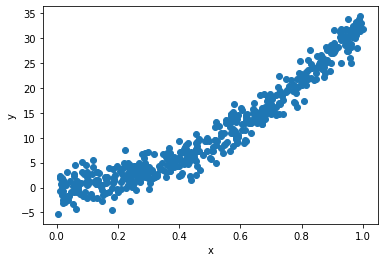

In [6]:
np.random.seed(0)

x = np.random.uniform(size=500)
y = 30 * x ** 2  + 3 * x  + 2 * np.random.normal(size=x.shape)

plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

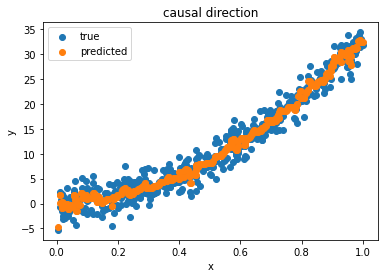

In [7]:
model = CatBoostRegressor(silent=True, iterations=500)
model.fit(x[:,None], y)
pred = model.predict(x[:,None])

plt.scatter(x, y, label="true")
plt.scatter(x, pred, label="predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("causal direction")
plt.show()

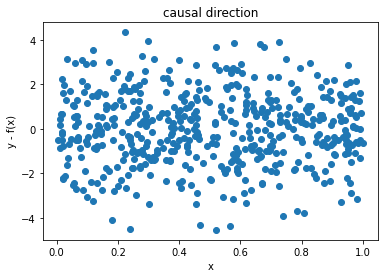

In [9]:
plt.scatter(x, y - pred)
plt.xlabel("x")
plt.ylabel("y - f(x)")
plt.title("causal direction")
plt.show()

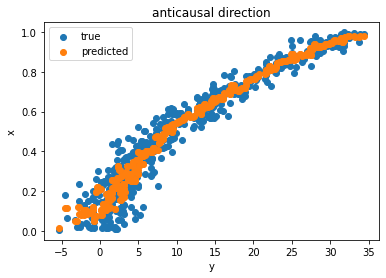

In [10]:
model = CatBoostRegressor(silent=True, iterations=500)
model.fit(y[:,None], x)
pred = model.predict(y[:,None])

plt.scatter(y, x, label="true")
plt.scatter(y, pred, label="predicted")
plt.xlabel("y")
plt.ylabel("x")
plt.legend()
plt.title("anticausal direction")
plt.show()

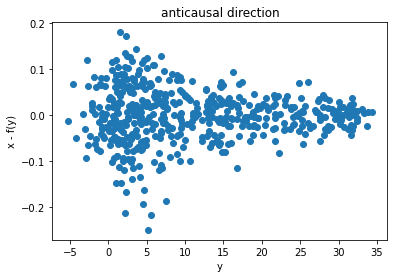

In [11]:
plt.scatter(y, x - pred)
plt.xlabel("y")
plt.ylabel("x - f(y)")
plt.title("anticausal direction")
plt.show()

In [13]:
df = pd.read_csv('temp-alt-2020.csv')
df

,Unnamed: 0,region,UF,city,lat,lon,temperature,altitude
0,0,SE,RJ,CAMPOS DOS GOYTACAZES - SAO TOME,"-22,04166666","-41,05166666",24.002001,-41.051667
1,0,CO,MT,SAO FELIX DO ARAGUAIA,"-11,61888888","-50,72777777",26.947313,-50.727778
2,0,N,PA,MARABA,"-5,366447","-49,051166",26.410281,-49.051166
3,0,CO,GO,RIO VERDE,"-17,785303","-50,964869",27.305761,-50.964869
4,0,S,RS,PORTO ALEGRE,"-30,05361111","-51,17472221",19.983030,-51.174722
...,...,...,...,...,...,...,...,...
563,0,CO,MT,SALTO DO CEU,"-15,12472221","-58,12722221",24.474166,-58.127222
564,0,SE,SP,VALPARAISO,"-21,31916666","-50,93027777",23.658756,-50.930278
565,0,S,RS,ALEGRETE,"-29,709083","-55,525486",19.718981,-55.525486
566,0,S,PR,CASTRO,"-24,786954","-49,999266",17.650484,-49.999266


In [14]:
x = df['altitude']
y = df['temperature']

model = CatBoostRegressor(silent=True, iterations=500)
model.fit(x[:, None], y)
pred = model.predict(x[:, None])

print("rmse:", np.sqrt(mean_squared_error(y, pred)))

rmse: 2.492526767477597


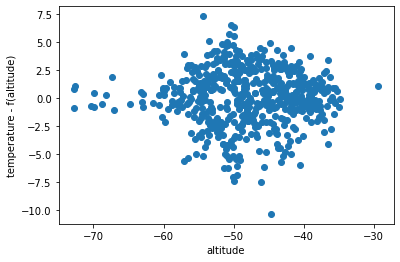

Correlation coefficient: 0.00012867904084942633


In [15]:
plt.scatter(x, y - pred)
plt.xlabel("altitude")
plt.ylabel("temperature - f(altitude)")
plt.show()

print("Correlation coefficient:", np.corrcoef(x, y - pred)[0][1])

In [16]:
y = df['altitude']
x = df['temperature']

model = CatBoostRegressor(silent=True, iterations=500)
model.fit(x[:, None], y)
pred = model.predict(x[:, None])

print("rmse:", np.sqrt(mean_squared_error(y, pred)))

rmse: 5.566182759163655


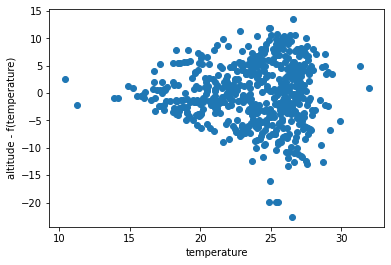

Correlation coefficient: 0.0018685877935827016


In [17]:
plt.scatter(x, y - pred)
plt.xlabel("temperature")
plt.ylabel("altitude - f(temperature)")
plt.show()

print("Correlation coefficient:", np.corrcoef(x, y - pred)[0][1])

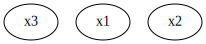

In [72]:
from causalgraphicalmodels import CausalGraphicalModel

path = CausalGraphicalModel(
    nodes = ["x1", "x2", "x3"],
    edges = []
)

path.draw()

In [94]:
generate_do(5, x2=2)

,x1,x2,x3
0,3.404614,2,-4.390021
1,2.465044,2,-4.384966
2,2.384362,2,-3.990816
3,2.918634,2,-3.773429
4,3.731850,2,-3.844505


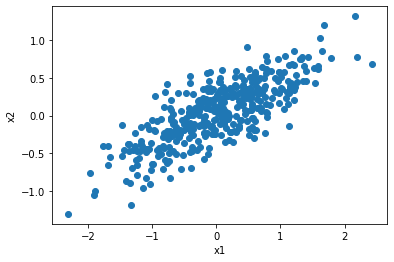

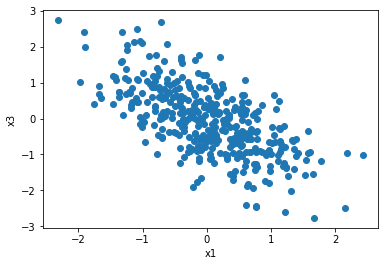

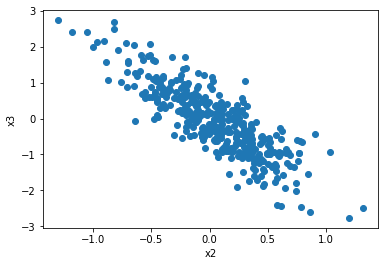

In [73]:
df = generate_do(400)


plt.scatter(df['x1'], df['x2'])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

plt.scatter(df['x1'], df['x3'])
plt.xlabel('x1')
plt.ylabel('x3')
plt.show()

plt.scatter(df['x2'], df['x3'])
plt.xlabel('x2')
plt.ylabel('x3')
plt.show()

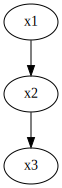

In [74]:
path = CausalGraphicalModel(
    nodes = ["x1", "x2", "x3"],
    edges = [("x1", "x2"), ("x2", "x3")]
)

path.draw()

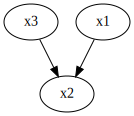

In [75]:
path = CausalGraphicalModel(
    nodes = ["x1", "x2", "x3"],
    edges = [("x1", "x2"), ("x3", "x2")]
)

path.draw()

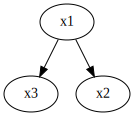

In [76]:

path = CausalGraphicalModel(
    nodes = ["x1", "x2", "x3"],
    edges = [("x1", "x2"), ("x1", "x3")]
)

path.draw()

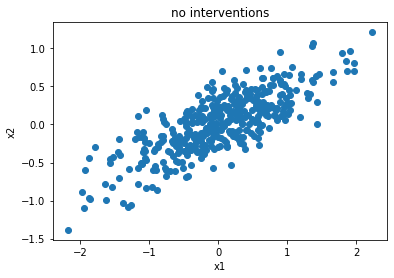

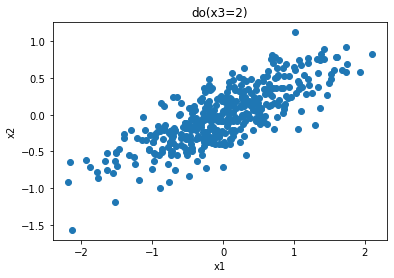

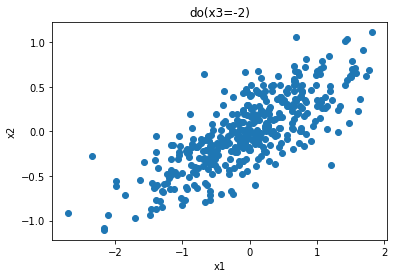

In [77]:
df = generate_do(400)

plt.scatter(df['x1'], df['x2'])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("no interventions")
plt.show()


df = generate_do(400, x3=2)

plt.scatter(df['x1'], df['x2'])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("do(x3=2)")
plt.show()

df = generate_do(400, x3=-2)

plt.scatter(df['x1'], df['x2'])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("do(x3=-2)")
plt.show()

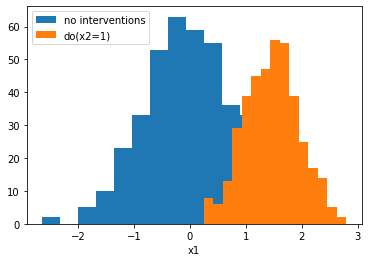

In [86]:
df = generate_do(400)

plt.hist(df['x1'], bins=15, label='no interventions')
plt.xlabel('x1')

df = generate_do(400, x2=1)

plt.hist(df['x1'], bins=15, label='do(x2=1)')
plt.xlabel('x1')

plt.legend()
plt.show()

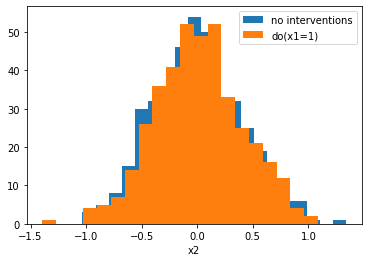

In [88]:
df = generate_do(400)

plt.hist(df['x2'], bins=20, label='no interventions')
plt.xlabel('x2')

df = generate_do(400, x1=1)

plt.hist(df['x2'], bins=20, label='do(x1=1)')
plt.xlabel('x2')

plt.legend()
plt.show()

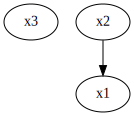

In [89]:
path = CausalGraphicalModel(
    nodes = ["x1", "x2", "x3"],
    edges = [("x2", "x1")]
)

path.draw()

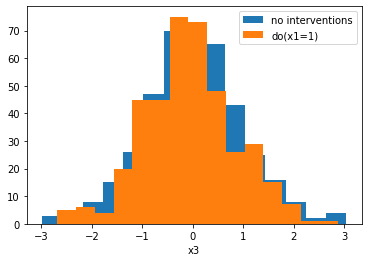

In [90]:
df = generate_do(400)

plt.hist(df['x3'], bins=15, label='no interventions')
plt.xlabel('x3')

df = generate_do(400, x1=1)

plt.hist(df['x3'], bins=15, label='do(x1=1)')
plt.xlabel('x3')

plt.legend()
plt.show()

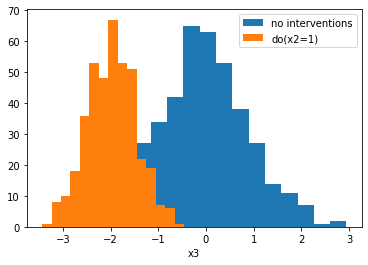

In [91]:
df = generate_do(400)

plt.hist(df['x3'], bins=15, label='no interventions')
plt.xlabel('x3')

df = generate_do(400, x2=1)

plt.hist(df['x3'], bins=15, label='do(x2=1)')
plt.xlabel('x3')

plt.legend()
plt.show()

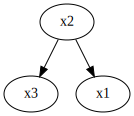

In [92]:
path = CausalGraphicalModel(
    nodes = ["x1", "x2", "x3"],
    edges = [("x2", "x1"), ("x2", "x3")]
)

path.draw()

In [63]:
df = generate(size=5000, env=1)

df

,x1,x2,y
0,0.052280,1.336258,0.880286
1,1.997987,5.652169,4.002280
2,0.986004,3.239293,1.625481
3,1.642314,3.929784,3.361534
4,0.341953,3.386048,1.364928
...,...,...,...
4995,1.049001,2.536351,2.174480
4996,-2.621531,-7.588075,-5.367224
4997,-0.444805,-1.388692,-1.042045
4998,-0.165220,0.226733,0.343659


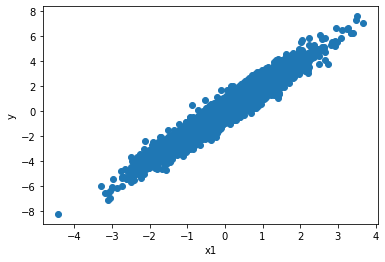

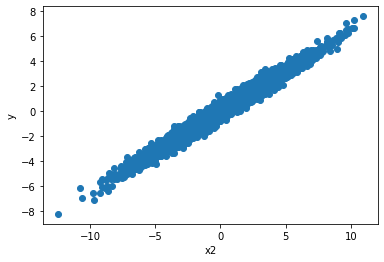

In [64]:
plt.scatter(df['x1'], df['y'])
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

plt.scatter(df['x2'], df['y'])
plt.xlabel('x2')
plt.ylabel('y')
plt.show()

In [65]:
df_train = df[:4000]
df_val = df[4000:]

sub1 = ['x1']
sub2 = ['x2']
sub12 = ['x1', 'x2']

subs = [sub1, sub2, sub12]

In [66]:
models = []

for sub in subs:
    model = LinearRegression()
    model.fit(df_train[sub], df_train['y'])
    
    pred_train = model.predict(df_train[sub])
    pred_val = model.predict(df_val[sub])
    print(*sub)
    print("MSE train:",  mean_squared_error(pred_train, df_train['y']),
          "val:", mean_squared_error(pred_val, df_val['y']),)
    models.append(model)

x1
MSE train: 0.24673831174487265 val: 0.24819364295730822
x2
MSE train: 0.10854494905725551 val: 0.1115884795463119
x1 x2
MSE train: 0.078649057683806 val: 0.07811645967958782


In [67]:
env = 1
df_test = generate(2000, env)
print("env =", env)
for i in range(len(subs)):
    model = models[i]

    pred_test = model.predict(df_test[subs[i]])
    print(*subs[i])
    print("MSE test:",  mean_squared_error(pred_test, df_test['y']))

env = 1
x1
MSE test: 0.2529503253509635
x2
MSE test: 0.10578588395631341
x1 x2
MSE test: 0.07499051260479558


In [68]:
env = 0.7
df_test = generate(2000, env)
print("env =", env)
for i in range(len(subs)):
    model = models[i]

    pred_test = model.predict(df_test[subs[i]])
    print(*subs[i])
    print("MSE test:",  mean_squared_error(pred_test, df_test['y']))

env = 0.7
x1
MSE test: 0.25706554748606447
x2
MSE test: 0.699667472887704
x1 x2
MSE test: 0.40804029906882366


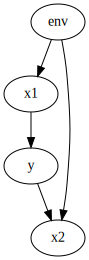

In [69]:
from causalgraphicalmodels import CausalGraphicalModel

path = CausalGraphicalModel(
    nodes = ["env", "x1", "y", "x2"],
    edges = [("env", "x1"), ("env", "x2"), ("x1", "y"), ("y", "x2")]
)

path.draw()

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

w, h = 10, 10

class AE(nn.Module):
    def __init__(self, hidden1=100, hidden2=100, code=6):
        super().__init__()

        self.enc1 = nn.Linear(h * w, hidden1)
        self.enc2 = nn.Linear(hidden1, hidden2)
        self.enc_code = nn.Linear(hidden2, code, bias=False)

        self.dec1 = nn.Linear(code, hidden2, bias=False)
        self.dec2 = nn.Linear(hidden2, hidden1)
        self.dec3 = nn.Linear(hidden1, h * w)

        self.act = torch.relu

    def forward(self, x):
        x = x.view(x.size(0), -1)
        act = self.act(self.enc1(x))
        act = self.act(self.enc2(act))

        code = self.act(self.enc_code(act))

        act = self.act(self.dec1(code))
        act = self.act(self.dec2(act))
        out = self.act(self.dec3(act))

        return out.view(x.size(0), h, w)


In [27]:
from torch.utils.data import TensorDataset, DataLoader

np.random.seed(0)

cnt = 100

data = np.zeros((cnt, w, h))

for im in range(cnt):
    fh, fw = 5, 5

    posi = np.random.randint(0, h - fh + 1)
    posj = np.random.randint(0, w - fw + 1)

    data[im][posi:posi + fh, posj:posj + fw] = 1

data += 0.03 * np.random.normal(size=data.shape)


train_data = data[:cnt//9*10]
test_data = data[cnt//9*10:]

train_dataset = TensorDataset(torch.tensor(train_data).float()) 
train_loader = DataLoader(train_dataset, batch_size=32) 

test_dataset = TensorDataset(torch.tensor(test_data).float()) 
test_loader = DataLoader(test_dataset, batch_size=32) 

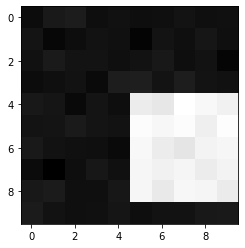

In [28]:
import matplotlib.pyplot as plt

plt.imshow(data[0], cmap='gray')
plt.show()

In [29]:
import torch.optim as optim
import random

seed = 3
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AE(code=2, hidden1=100, hidden2=100).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.MSELoss()

epochs = 100

In [30]:
for epoch in range(epochs):
    loss = 0
    for batch in train_loader:
        batch = batch[0].to(device)

        optimizer.zero_grad()
        
        outputs = model(batch)
        train_loss = criterion(outputs, batch)
        train_loss.backward()

        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 10/100, loss = 0.176844
epoch : 20/100, loss = 0.134254
epoch : 30/100, loss = 0.104045
epoch : 40/100, loss = 0.092457
epoch : 50/100, loss = 0.083364
epoch : 60/100, loss = 0.075915
epoch : 70/100, loss = 0.071274
epoch : 80/100, loss = 0.070133
epoch : 90/100, loss = 0.068383
epoch : 100/100, loss = 0.065504


In [31]:
def get_code(self, input, output):
    print(output)

model.enc_code.register_forward_hook(get_code)

model = model.to('cpu')

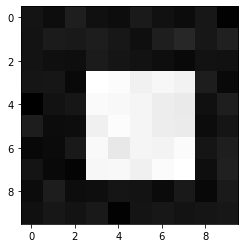

tensor([[5.4866, 4.9387]], grad_fn=<MmBackward>)


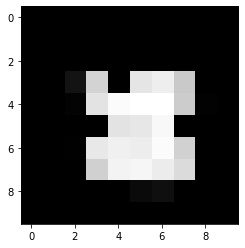

In [32]:
i = 2

plt.imshow(train_data[i], cmap='gray')
plt.show()

x = torch.tensor(train_data[i:i+1]).float()
plt.imshow(model(x)[0].detach().numpy(), cmap='gray')
plt.show()

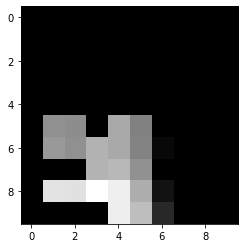

In [50]:
def decode(code, model):
    act = model.act(model.dec1(code))
    act = model.act(model.dec2(act))
    out = model.act(model.dec3(act))

    return out.view(x.size(0), h, w)

code = torch.tensor([7, 2]).float()
plt.imshow(decode(code, model)[0].detach().numpy(), cmap='gray')
plt.show()